# Load and create data sets

Load data.

In [1]:
### LINES TO IMPORT THE DECONFOUNDER PACKAGE IN THE PARENT FOLDER ###
import os
import sys
sys.path.append("..")
### IMPORTS
from deconfounder.causal_tree import CausalTree
from deconfounder.causal_forest import CausalForest
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
from numpy.polynomial.polynomial import polyfit
import pandas as pd
import scipy.stats as st
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
import time

# Load data
df = pd.read_csv("../data/criteo-uplift-v2.1.csv")
df = df.sample(frac=1, random_state=42)
all_features = df.columns.values[:12].tolist()

Find the feature that is correalted the most with the outcome and remove that feature (i.e., the confounder).

In [2]:
corr_matrix = df[all_features + ['visit']].corr()
confounder = corr_matrix['visit'][:-1].sort_values().index.values[-1]
print(confounder)
limited_features = list(all_features)
limited_features.remove(confounder)

f9


Obtain observational data. Drop observations using the confounder.

In [7]:
def print_outcomes(data):
    means = data.groupby('treatment').visit.mean()
    print(f"Size of data set: {data.shape[0]:,}")
    print(f"Avg. Outcome (treated): {np.round(means.loc[1]*100, 2)}%")
    print(f"Avg. Outcome (control): {np.round(means.loc[0]*100, 2)}%")
    print(f"Estimated avg. effect: {np.round((means.loc[1]-means.loc[0])*100, 2)}%")

train_frac = 0.5
train_size = int(df.shape[0]*train_frac)
train_size = 1000000
obs_df = df[:train_size]
train_df = df[:train_size]
drop_frac = 0.1

conf_ranking = obs_df[confounder].rank(method="first")
keep =  ((obs_df.treatment == 1) & (conf_ranking > int(train_size * drop_frac))) | \
        ((obs_df.treatment == 0) & (conf_ranking < int(train_size * (1 - drop_frac))))
obs_df = train_df[keep]
print("Observational (naive) setup")
print_outcomes(obs_df)
print("-------------")
exp_df = train_df.sample(n=obs_df.shape[0],random_state=42)
print("Experimental setup")
print_outcomes(exp_df)
print("-------------")
print("Entire data")
print_outcomes(df)

Observational (naive) setup
Size of data set: 901,088
Avg. Outcome (treated): 5.34%
Avg. Outcome (control): 1.26%
Estimated avg. effect: 4.08%
-------------
Experimental setup
Size of data set: 901,088
Avg. Outcome (treated): 4.9%
Avg. Outcome (control): 3.85%
Estimated avg. effect: 1.05%
-------------
Entire data
Size of data set: 13,979,592
Avg. Outcome (treated): 4.85%
Avg. Outcome (control): 3.82%
Estimated avg. effect: 1.03%


Build causal tree using observational data. Control for observable confounding.

In [33]:
from sklearn.ensemble import RandomForestRegressor

def fit_tree(df_causal, tree_type=CausalForest, min_samples_leaf=5000, tune=False, params=None, scoring=None):    
    X = df_causal[limited_features + ['treatment']].rename(columns={"treatment":"treated"})
    y =  df_causal.visit
    # Fit and tune causal tree
    start_time = time.time()
    if tune:
        if params is None:
            params = range(1000, 10000, 1000)
        tuned_parameters = [{'min_samples_leaf': params}]
        grid_tree = GridSearchCV(tree_type(random_state=42, n_estimators=10), tuned_parameters, cv=4, 
                                 verbose=10, n_jobs=-1, scoring=scoring)
        grid_tree.fit(X, y)
        print("Best parameters set found on development set:")
        print(grid_tree.best_params_)
        tree_model = grid_tree.best_estimator_
    else:
        tree_model = tree_type(min_samples_leaf=min_samples_leaf, random_state=42, n_estimators=10)
        tree_model.fit(X, y)   
    print("--- Time to fit (and tune) causal tree %s seconds ---" % (time.time() - start_time))
    return tree_model

#obs_tree = fit_tree(obs_df, tune=True, params=[8000, 16000, 32000, 64000, 128000])
#obs_tree = fit_tree(obs_df, min_samples_leaf=50000)
obs_tree = fit_tree(obs_df, tree_type=CausalForest, tune=True, params=[50000])

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   21.5s remaining:   21.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   21.5s remaining:    0.0s


Exception: Data must be 1-dimensional

In [32]:
X = obs_df[limited_features + ['treatment']].rename(columns={"treatment":"treated"})
y =  obs_df.visit
obs_tree.score(X, y)

0.2167852302164871

Obtain evaluation data

In [18]:
eval_df = df[train_size:].copy()

Estimated average causal effect after accounting for observed confounding. 

In [25]:
print("Observational ('smart') setup")
obs_preds = obs_tree.predict(eval_df[limited_features])
obs_avg_effect = obs_preds.mean()
print(f"Estimated avg. effect: {np.round(obs_avg_effect*100, 2)}%")

Observational ('smart') setup
Estimated avg. effect: 3.02%


# Does the confounding hurt decision making?

In [23]:
exp_tree = fit_tree(exp_df, min_samples_leaf=obs_tree.min_samples_leaf)
exp_preds = exp_tree.predict(eval_df[limited_features])

--- Time to fit (and tune) causal tree 21.872618675231934 seconds ---


In this case, the experimental data is large, so it hurts.

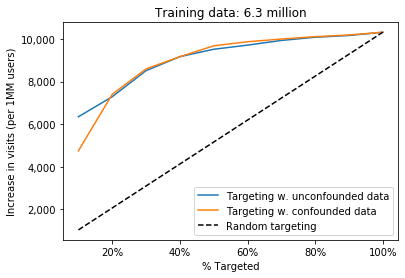

In [26]:
means = eval_df.groupby('treatment').visit.mean()
avg_effect = means.loc[1]-means.loc[0]
total_impressions = 1000000

def plot_random(e_df):
    means = e_df.groupby('treatment').visit.mean()
    avg_effect = means.loc[1]-means.loc[0]
    size = 10
    fractions = (np.arange(size)+1)/10
    plt.plot(fractions*100, fractions*avg_effect*total_impressions, 
             color='black', linestyle='dashed', label="Random targeting")
    plt.legend()

def evaluate(e_df, title):
    e_df = e_df.sort_values('pred', ascending=False)
    cum_per = np.arange(e_df.shape[0]) / e_df.shape[0]
    fractions = []
    effects = []
    size = 10
    for i in range(size):
        targeted = cum_per < (i+1)/size
        fraction = targeted.mean()
        avg_outcomes = e_df[targeted].groupby('treatment').visit.mean()
        effect = (avg_outcomes.loc[1] - avg_outcomes.loc[0]) * fraction * total_impressions
        fractions.append(fraction)
        effects.append(effect)
    figs = plt.plot(np.array(fractions)*100, effects, label=title)
    plt.xlabel("% Targeted")
    plt.ylabel("Increase in visits (per 1MM users)")
    # Set Y axis
    fmt = '{x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    figs[0].axes.yaxis.set_major_formatter(tick)
    # Set X axis
    figs[0].axes.xaxis.set_major_formatter(mtick.PercentFormatter())
    plt.legend()

eval_df['pred'] = exp_preds
evaluate(eval_df, "Targeting w. unconfounded data")
eval_df['pred'] = obs_preds
evaluate(eval_df, "Targeting w. confounded data")
plot_random(eval_df)
plt.title("Training data: 6.3 million")
plt.show()

But if there was less data, the bias may actually cancel some errors due to variance, benefiting decision making.

--- Time to fit (and tune) causal tree 0.6173367500305176 seconds ---
--- Time to fit (and tune) causal tree 0.6119301319122314 seconds ---


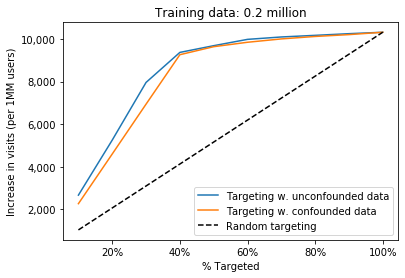

In [27]:
e_small_tree = fit_tree(exp_df.sample(200000, random_state=42), min_samples_leaf=exp_tree.min_samples_leaf)
o_small_tree = fit_tree(obs_df.sample(200000, random_state=42), min_samples_leaf=obs_tree.min_samples_leaf)
e_small_preds = e_small_tree.predict(eval_df[limited_features])
o_small_preds = o_small_tree.predict(eval_df[limited_features])
eval_df['pred'] = e_small_preds
evaluate(eval_df, "Targeting w. unconfounded data")
eval_df['pred'] = o_small_preds
evaluate(eval_df, "Targeting w. confounded data")
plot_random(eval_df)
plt.title("Training data: 0.2 million")
plt.show()

# Approach 1: Domain Knowledge

Fit outcome tree.

In [9]:
outcome_tree = fit_tree(train_df, tree_type=DecisionTreeClassifier, tune=True,
                        scoring='roc_auc', params=[2000, 4000, 8000, 16000, 32000])

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  21 out of  25 | elapsed:  8.4min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  9.2min finished


Best parameters set found on development set:
{'min_samples_leaf': 4000}
--- Time to fit (and tune) causal tree 619.5404572486877 seconds ---


Check out if there is a correlation between outcomes and estimated effects.

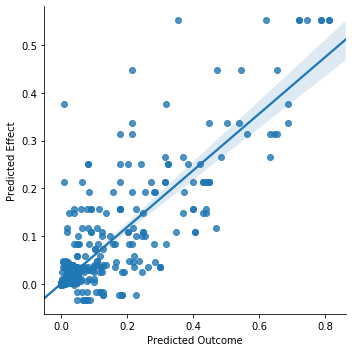

In [16]:
outcome_preds = outcome_tree.predict_proba(eval_df[limited_features + ['treatment']])[:, 1]
obs_preds = obs_tree.predict(eval_df[limited_features])
df_pred = pd.DataFrame({"Predicted Outcome": outcome_preds, "Predicted Effect": obs_preds})
sns.lmplot(x='Predicted Outcome',y='Predicted Effect',data=df_pred.sample(1000, random_state=42),fit_reg=True) 

Check out Spearman and Pearson correlation coefficients.

In [17]:
print(spearmanr(obs_preds, outcome_preds))
print(np.corrcoef(obs_preds, outcome_preds)[0, 1])

SpearmanrResult(correlation=0.740440481780107, pvalue=0.0)
0.8632594455755702


Of course, this correlation is likely to be exaggerated. Compare with a model trained with unconfounded data.

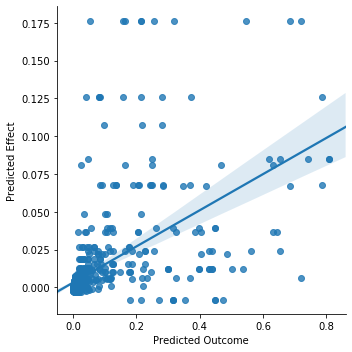

In [19]:
df_pred = pd.DataFrame({"Predicted Outcome": outcome_preds, "Predicted Effect": exp_preds})
sns.lmplot(x='Predicted Outcome',y='Predicted Effect',data=df_pred.sample(1000, random_state=42),fit_reg=True) 

In [20]:
print(spearmanr(exp_preds, outcome_preds))
print(np.corrcoef(exp_preds, outcome_preds)[0, 1])

SpearmanrResult(correlation=0.5888642575188885, pvalue=0.0)
0.5692112022068051


# Approach 2: Find out which customers are profitable

Suppose visit value is \\$ 0.50 and the cost is \\$ 0.01. How does the bias may affect ability to identify profitable customers?

In [91]:
visit_value = 0.5
ad_cost = 0.01
boundary = ad_cost/(visit_value+ad_cost)

def get_avg_benefit(e_df, boundary=None):
    if boundary is None:
        boundary = ad_cost/(visit_value+ad_cost)
    targeted = e_df.pred > boundary 
    avg_outcomes = e_df[targeted].groupby('treatment').visit.mean()
    fraction = targeted.mean()
    additional_visits = (avg_outcomes.loc[1] - avg_outcomes.loc[0]) * fraction 
    benefit = (additional_visits*visit_value - fraction*ad_cost)*total_impressions
    print(f"Benefit ($) per 1 MM users: {round(benefit):,}")
    return benefit

print("Real benefit (compared with sensitivity analysis)")
print("------")
print("Observational")
eval_df['pred'] = obs_preds
obs_benefit = get_avg_benefit(eval_df)
print("Experimental")
eval_df['pred'] = exp_preds
exp_benefit = get_avg_benefit(eval_df)

Real benefit (compared with sensitivity analysis)
------
Observational
Benefit ($) per 1 MM users: 1,801.0
Experimental
Benefit ($) per 1 MM users: 2,277.0


Get cross-validation predictions.

In [28]:
X = obs_df[limited_features + ['treatment']].rename(columns={"treatment":"treated"})
y =  obs_df.visit
cross_preds = cross_val_predict(CausalTree(min_samples_leaf=obs_tree.min_samples_leaf, random_state=42), 
                                X, y, cv=5, verbose=10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   50.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.1min finished


Assess how much could the bias affect the decisions.

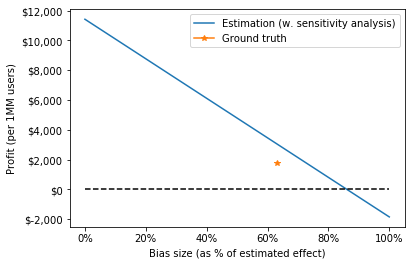

In [92]:
targeted = cross_preds > boundary
biased_avg_effect = obs_preds.mean()
estimated_effects = obs_tree.predict(obs_df[limited_features])

real_avg_bias = round(1 - avg_effect/biased_avg_effect, 2)

bias_sizes = np.arange(11)/10
benefits = []
for bias_size in bias_sizes:
    real_size = (1-bias_size)
    additional_visits = ((estimated_effects * real_size) * targeted).mean()
    benefit =  round((additional_visits*visit_value - targeted.mean()*ad_cost)*total_impressions)
    benefits.append(benefit)

figs = plt.plot(bias_sizes*100, benefits, label="Estimation (w. sensitivity analysis)")
plt.xlabel("Bias size (as % of estimated effect)")
plt.ylabel("Profit (per 1MM users)")
# Set Y axis
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
figs[0].axes.yaxis.set_major_formatter(tick)
# Set X axis
figs[0].axes.xaxis.set_major_formatter(mtick.PercentFormatter())
# Break-even line
plt.plot([0, 100], [0, 0], linestyle='--', color='black')
plt.plot([real_avg_bias*100], [obs_benefit], marker="*", label="Ground truth")
plt.legend()

# Approach 3: What if there is some experimental data?

What's the best tree we could get with limited experimental data? 

In [93]:
limited_exp = exp_df.sample(50000,random_state=42)
limited_tree = fit_tree(limited_exp, tune=True, params=np.arange(1, 11)*1000)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.9s finished


Best parameters set found on development set:
{'min_samples_leaf': 2000}
--- Time to fit (and tune) causal tree 6.239730596542358 seconds ---


Compare each other. Experimental does better.

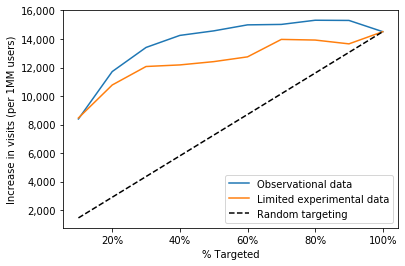

In [94]:
X = limited_exp[limited_features + ['treatment']].rename(columns={"treatment":"treated"})
y =  limited_exp.visit
exp_cross_preds = cross_val_predict(CausalTree(min_samples_leaf=limited_tree.min_samples_leaf, random_state=42), 
                                    X, y, cv=10)

copy_exp_df = limited_exp.copy()

copy_exp_df['pred'] = obs_tree.predict(copy_exp_df[limited_features])
evaluate(copy_exp_df, "Observational data")

copy_exp_df['pred'] = exp_cross_preds
evaluate(copy_exp_df, "Limited experimental data")
plot_random(copy_exp_df)

Real evaluation set. Does better except for cases where treatments are very expensive.

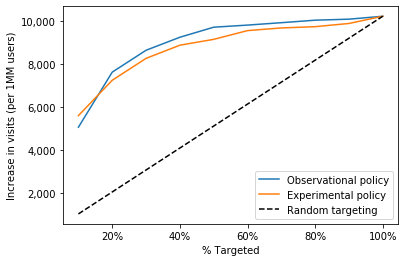

In [95]:
eval_df['pred'] = obs_preds
evaluate(eval_df, "Observational policy")
eval_df['pred'] = limited_tree.predict(eval_df[limited_features])
evaluate(eval_df, "Experimental policy")
plot_random(eval_df)
plt.show()

# Approach 4: Benefit vs. cost in experimentation

In [65]:
print("Observational")
eval_df['pred'] = obs_preds
obs_benefit = get_avg_benefit(eval_df)
exp_benefits = []
last_best = 2000
    
for sample_size in [50000, 100000, 500000, 2000000, 6000000]:
    print(sample_size)
    limited_exp = exp_df.sample(sample_size,random_state=42)
    if sample_size == exp_df.shape[0]:
        limited_tree = fit_tree(limited_exp, min_samples_leaf=obs_tree.min_samples_leaf)
    else:
        params = [2000, 4000, 8000, 16000, 32000, 64000]
        params = params[params.index(last_best):]
        limited_tree = fit_tree(limited_exp, tune=True, params=params)
        last_best = limited_tree.min_samples_leaf
        print(last_best)
    eval_df['pred'] = limited_tree.predict(eval_df[limited_features])
    exp_benefit = get_avg_benefit(eval_df)
    exp_benefits.append(exp_benefit)
    print(f"Improvement: {exp_benefit - obs_benefit}")
    print("------------------")

Observational
Benefit ($): 1,801.0
50000
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.2s finished


Best parameters set found on development set:
{'min_samples_leaf': 2000}
--- Time to fit (and tune) causal tree 1.5071678161621094 seconds ---
2000
Benefit ($): 1,626.0
Improvement: -175.65711755426992
------------------
100000
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:    2.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.4s finished


Best parameters set found on development set:
{'min_samples_leaf': 4000}
--- Time to fit (and tune) causal tree 2.9306795597076416 seconds ---
4000
Benefit ($): 2,083.0
Improvement: 281.33625139336596
------------------
500000
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  21 out of  25 | elapsed:   18.3s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   19.5s finished


Best parameters set found on development set:
{'min_samples_leaf': 16000}
--- Time to fit (and tune) causal tree 22.294957399368286 seconds ---
16000
Benefit ($): 2,085.0
Improvement: 284.0916000173563
------------------
2000000
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  1.1min remaining:   34.1s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  1.2min remaining:   17.7s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.5min finished


Best parameters set found on development set:
{'min_samples_leaf': 32000}
--- Time to fit (and tune) causal tree 105.38118600845337 seconds ---
32000
Benefit ($): 2,250.0
Improvement: 449.12381268714057
------------------
6000000
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  2.7min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  2.8min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.5min finished


Best parameters set found on development set:
{'min_samples_leaf': 32000}
--- Time to fit (and tune) causal tree 270.3515684604645 seconds ---
32000
Benefit ($): 2,289.0
Improvement: 488.09286817707584
------------------


In [97]:
eval_df['pred'] = np.random.uniform(eval_df.shape[0])
print("Random targeting")
random_benefit = get_avg_benefit(eval_df)

Random targeting
Benefit ($) per 1 MM users: -4,889.0


In [101]:
break_even_ratios = (obs_benefit - random_benefit)/(np.array(exp_benefits) - obs_benefit)
print("Minimum inference set sizes (in millions)")
np.array(break_even_ratios[1:]) * np.array([100000, 500000, 2000000, 6000000]) / 1000000

Minimum inference set sizes (in millions)


array([ 2.37793937, 11.77438103, 29.79136399, 82.23851557])

# Setup

1. Show that we are overestimating the effect by a lot. 
2. Domain Knowledge: Do we know anything about the nature of the confounding? In the advertising setup, is very common for ads to be targeted to the people most likely to convert. In other words, the more likely someone is to convert, the more likely this person is to be treated, so confounding is likely to be stronger for likely buyers. But... If the people more likely to convert are also more likely to be affected, that confounding will not be particularly harmful for decision making. We can check whether outcomes and effects seem to be correlated in the observational data. This is the case: so, we should expect to overestimate the effect for individuals with larger effects, which should be (in general) helpful. Show that the confounding is helpful for cases where there is little data (bias helps!). The bias is less helpful the more data we get. Emphasize that this is helpful to identify the people most likely to convert, not to identify the profitable individuals.
3. Sensitivity analysis: Basic setup, we could assess how much are we overestimating things with a simple approach. In practice, that may be too simplistic, because the confounding may vary quite a bit. Use a beta distribution of the confounding bias. Heat map varying the degree of confounding bias and the variance (used to assess how much the bias could vary across individuals). According to the analysis we should be fine unless the variance is too large, or the degree of confounding is too large. 
4. We have some experimental data available. Should we use the experimental data or the observational data? Use experimental data as a test set.
5. What if we were to invest in the experiment anyway. Would that lead to better results?